<center><h1>MLP Pipeline & Optimization Methods</h1>
    <h2>Rebecca Hinrichs</h2>
    <h3>Data Mining</h3>
    <h4>1 Nov 2022</h4></center>

***

Using Python's 'Multilayer Perceptron' neural network machine learning algorithm, we will explore the database `S1_Originaldata.csv` containing data collected from cancer patients fighting glioblastoma. The data consists of measurements of neoplastic astrocytes (cells) from the periphery and tumor core. Our goal is to design a neural network model which would help us predict the infiltration potency of these cells. We will utilize a MultiLayer Perceptron (MLP) architecture in order to allow the data to model itself using guidance from an adaptive deep learning algorithm found in Python's H20 Library. Finally, we will implement parameter optimization techniques in order to help us achieve as high of an accuracy reading as possible, and will discuss our findings.

***

In [27]:
filename = 'S1_Originaldata.csv'

In [28]:
# EDA Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from collections import Counter
# Data Pre-Processing Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN
# Machine Learning Libraries
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, cross_val_score, RepeatedStratifiedKFold
# Suppress version depreciation warnings
import warnings
warnings.filterwarnings('ignore')

***
# *** Exploratory Data Analysis ***
We'll begin our study by evaluating the data in our database. We'll explore the nature of the data collected, its terms of measurements, whether it contains any incomplete records or has any outlier measurements which could affect its overall statistics, and the nature of the classification labels in relationship to one another over the overall database.
<br><br>
**Missing values** (or null values) affect the statistical inferences we'll be making when applying our classification models. For example: if Class A's classification model depends on 3 features but Class B has the ability to be weighed against 5 features, our odds of correctly classifying a Class B label are greater than correctly classifying a Class A label.
<br><br>
**Zero values** behave similarly to null values, but instead of being overlooked, are included as a measurement of value zero. For this reason, we believe it is always good practice to include these questions in our forensics upon data collection, in order that we may include or omit zero or omitted values as relevant to feature classification.
<br><br>
Finally we'll observe the nature of the **classification labels**- for example: are they categorical, ordinal, or continuous (probabilistic)? Are there significant disparities between the classes? The answers to these questions will help us construct the best machine learning model for our data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Columns: 16384 entries, class to PPP1R3D
dtypes: float64(12979), int64(3404), object(1)
memory usage: 55.5+ MB
None


<<<-------------------------------- REVIEWING DATABASE RECORDS -------------------------------->>>


The database `S1_Originaldata.csv` contains 444 rows x 16384 columns.

The first ten names of its 16384 variables (features) are:
class
1/2-SBSRNA4
A1BG
A1BG-AS1
A1CF
A2LD1
A2M
A2ML1
A2MP1
A4GALT

We can get a snapshot of the first 5 rows of the data available using head().
From this small sample we can estimate how each feature has been recorded:

             class  1/2-SBSRNA4  A1BG  A1BG-AS1  A1CF  A2LD1       A2M  A2ML1  \
0  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  0.000000    0.0   
1  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  0.000000    0.0   
2  Neoplastic_Core          0.0   0.0       0.0   0.0    0.0  3.812781    0.0   
3  Neoplastic_Core          0.0   

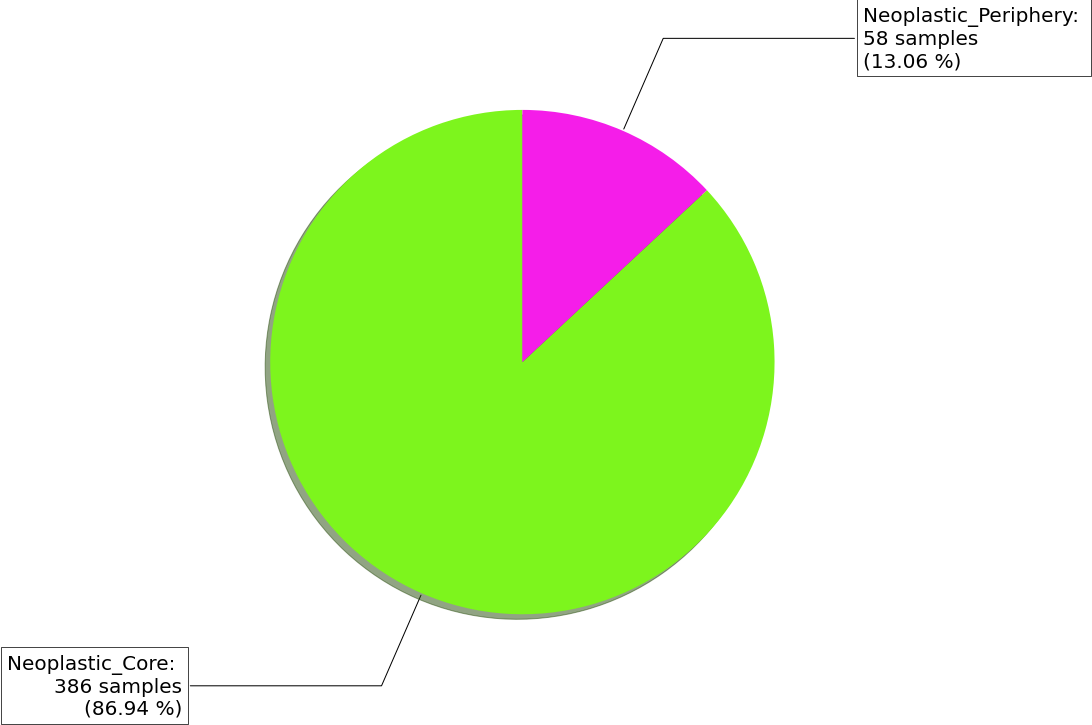


Additionally, we observe the label count distribution in terms of frequency as a histogram:


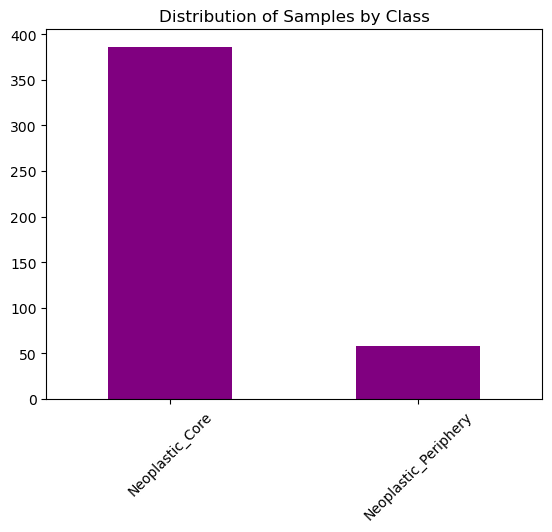



<<<-------------------------------- END OF DATA ANALYSIS -------------------------------->>>




In [29]:
# Function to do a full exploratory data analysis on a single filename
def eda_labels(filename):
    
    # Import data
    data = pd.read_csv(filename)
    
    # Demonstrate dataframe specs
    print(data.info())
    
    # Local variables
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    colnames = [x for x in data.columns]
    
    print('\n\n<<<-------------------------------- REVIEWING DATABASE RECORDS -------------------------------->>>\n\n')
    
    # Observe Data Records
    print(f'The database `{filename}` contains {num_rows} rows x {num_cols} columns.')
    print(f'\nThe first ten names of its {num_cols} variables (features) are:')
    [print(i) for i in colnames[:10]]

    # Summarize the Data
    print('\nWe can get a snapshot of the first 5 rows of the data available using head().')
    print('From this small sample we can estimate how each feature has been recorded:\n')
    print(data.head(),'\n')
    
    # Observe the Data Types
    import numpy as np
    print(f'The data types of each column are \n{data.dtypes}\n')
    class_type = 'string' if (data[colnames[0]].dtype == object) else 'numeric'
    print(f'The class labels are of data type: {class_type}\n')
    
    # Looking for empty values
    vals = ['null','zero']
    for x in vals:
        if x == 'null':
            col_sum = data.isna().sum()
        else:
            col_sum = (data==0).sum()
        print(f'<< ---------- {x} values ---------- >> ')
        print(f'\nThe total number of cells containing {x} values in our data ' \
              f'set is {col_sum.sum()} which is {round(col_sum.sum()/(num_rows*num_cols)*100,2)}% of our total data.\n')
        if col_sum.sum() > 0:
            five_number = [10, 25, 50, 75, 90, 100]
            for i in five_number:
                print(f'{len(col_sum[(col_sum/(num_rows) >= i/100)])} features- ' \
                      f'or {round(len(col_sum[(col_sum/(num_rows) >= i/100)])/num_cols*100,2)}% percent of the dataset- ' \
                      f' contain {i}% or more of their data as {x} ')
            print(f'\nThe remaining ' \
                  f'{len(col_sum[(col_sum/(num_rows) < .1)])} ' \
                  f'{x} values exist among variables which contain under 10% of their data as {x}.\n')
            
    print('\n\n<<<-------------------------------- ANALYZING CLASS DISTRIBUTION -------------------------------->>>\n\n')
    
    # Evaluate label assignment distribution of records
    data_class_dist = data.groupby(colnames[0]).size()
    print('\nThe number of records per class assignment is as follows:')
    print(data_class_dist,'\n')
    
    # Confirm label distribution among record totals
    class_equality = True
    for ea in data_class_dist:
        if ea == (data_class_dist.iloc(0)):
            continue
        else:
            class_equality = False
    if_even = str('an even') if (class_equality == True) else str('an uneven')
    if_equal = 'is' if (data[colnames[0]].count() == num_rows) else 'is NOT'
    print(f'\nGiven these counts, we observe {if_even} ' \
          f'distribution among a total of {len(data_class_dist)} classes,\n\tfrom ' \
          f'{min(data_class_dist)} to {max(data_class_dist)} records apiece.\n')
    print(f'The total class assignment of ' \
          f'{data[colnames[0]].count()} {if_equal} ' \
          f'equivalent to our record total of {num_rows}.\n')
    print('Among the classes, ')
    for y in range(len(data_class_dist)):
        print(f'`{np.unique(data[colnames[0]])[y]:<25}` accounts for ' \
              f'{len(data[data[colnames[0]].values==np.unique(data[colnames[0]])[y]])} or ' \
              f'{round((len(data[data[colnames[0]].values==np.unique(data[colnames[0]])[y]]) / num_rows) * 100,2)}' \
              f'% percent of record total {num_rows}')
    
    # Display label distribution as proportions of data set
    print('\nThis distribution may be observed as a pie chart to describe proportions of the labels:')    
    print("Rows, Columns:", data.shape)
    print('\nClass Distribution among All Variables:')
    Classes = data.groupby(colnames[0]).size()
    labels = Classes.index.values
    sizes = Classes.values
    label_list = []
    for k in range(0,labels.size):
      text = str(labels[k])+': \n'+str(sizes[k])+' samples\n({:,.2f} %)'.format((100*sizes[k]/sum(sizes)))
      label_list.append(text)
    colors = ['#7df51d','#f51de9']
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=0, va="center")
    fig,ax1 = plt.subplots(figsize=(10,10),ncols=1,nrows=1)
    plt.rc('font', size=20)
    wedges, texts = ax1.pie(sizes, shadow=True, colors=colors, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Demonstrate label distribution as pie chart
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax1.annotate(label_list[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.show()
    
    # Display label distribution as frequency distribution (histogram)
    print('\nAdditionally, we observe the label count distribution in terms of frequency as a histogram:')
    plt.rcParams.update(plt.rcParamsDefault)  # return font sizes to default
    data[colnames[0]].value_counts().plot(kind='bar', color='purple', title='Distribution of Samples by Class')
    plt.xticks(rotation=45)
    plt.show()
    
    print('\n\n<<<-------------------------------- END OF DATA ANALYSIS -------------------------------->>>\n\n')
            
    return data, class_equality

# Run function on data set and store dataframe and boolean whether classes are imbalanced
data, class_equality = eda_labels(filename)

***
# * Data Pre-Processing *
To begin, we will reserve 10% of our entire dataset for a final test of our prediction model. The remaining 90%, which we will refer to as our *modeling data*, will be the data with which we create our prediction model. This data reservation process is referred to **leave one out cross-validation**, and when done properly, allows us to understand how well our final trained & tested model can generalize, as well as how well it can predict, unseen data. It is important to point out the order with which we must do this. First, the data remains in its native, recorded state as it was imported with the rest of the data. The data is reserved at random selection in order to maintain statistical integrity. Second, it is important to keep the data completely unprocessed before any collinearity or scaling adjustments are performed, in order to ensure the balance of sensitivity and specificity of our final prediction model maintains its integrity. 
<br><br>
Finally, rather than performing any sort of feature selection *before* getting into cross-validation, we propose that performing feature selection *during* cross-validation would allow the selected features to only be derived from the training data and not from the joint pool of both training and validation data. This is particularly important when we are presented with **imbalanced data**, due to the fact that the MLP classifier we intend to work with uses statistical processes detecting entropy in order to model prediction data which exacerbate outlier data by amplifying its impact. In short, balancing our classes will help our model treat *normal* samples as equally as it will treat *relevant* samples, since the majority of samples contain `Neoplastic_Core` references and few contain `Neoplastic_Periphery`. Being that our proposal implies the relative importance of our minority class, reserving an untouched testing sample immediately before processing our data, and then properly balancing our classes before fitting them to our classifier is imperative in our order of operations.
<br><br>
Therefore, our approach follows these 5-steps *prior* to fitting the data to our model for training:
  - 1) Leave One Participant Out for Cross-Validation
  - 2) Perform Dimensionality Reduction by removing Sparse & Collinear Variables
  - 3) Normalize the Data in order to reduce the impact of outlier data points
  - 4) Split the training/testing data 
  - 5) Address imbalanced class data on the training set prior to fitting the model

###### Step 1) Leave One Participant Out for Cross-Validation

In [49]:
# Apply data partitioning technique on dataframe, where 
# PARAMETERS: dataframe assumes any EDA on the full imported data set has already been completed

def reserve_data(dataframe):
    # Reserve 10% of randomized dataset for final test on finalized model
    try:
        print('\n\n<<<---------------------------- BEGIN PREPARING DATA ---------------------------->>>\n\n')
        model_data = dataframe.sample(frac=0.9, random_state=786).reset_index(drop=True)
        reserve_data = dataframe.drop(model_data.index).reset_index(drop=True)  # Remains unprocessed
        print('\tRandomized Data for Modeling:       ' + str(model_data.shape) + '  (rows, columns)')
        print('\tReserved Data for Cross-Validation:  ' + str(reserve_data.shape) + '  (rows, columns)')
        print('\n\n<<<-------------------------- DATA IS READY TO PROCESS -------------------------->>>\n\n')
    except:
        print('\n\n<<<----------- ERROR: There was a problem reserving the data!----------->>>\n\n')
    
    return model_data, reserve_data


# Run function on dataframe to partition data for cross-validation
data_seen, data_unseen = reserve_data(data)



<<<---------------------------- BEGIN PREPARING DATA ---------------------------->>>


	Randomized Data for Modeling:       (400, 16384)  (rows, columns)
	Reserved Data for Cross-Validation:  (44, 16384)  (rows, columns)


<<<-------------------------- DATA IS READY TO PROCESS -------------------------->>>




Our method in performing dimensionality reduction will be to remove collinear data from our modeling data. **Collinear variables** are those which present a highly collinear relationships, exposed by means of a correlation matrix. Highly correlated variables present inflation to our variance because interdependency of variables pull weight from the coefficients of other independent variables in relationship to the output. In other words, in order to define as succint a formula as possible (the linear equation our model will formulate), we must make sure every variable as input is completely independent. We will implement a threshold of $95\%$ collinearity required in order to discard any particular variable as redundant.
<br><br>
**Data scaling** is a valuable technique to fit our data to a normalized interval, and is particularly useful when we can observe a large disparity between the max() and min() values and the large gaps between our averages, we could benefit by scaling our data into an interval described by standard deviations rather than discrete measurements. Normalizing our training set decreases the effect of 'noise' in order to achieve as high precision as possible.
###### Steps 2-3) Perform Dimensionality Reduction & Normalize the Data

In [31]:
# Apply data pre-processing techniques on dataframe, where 
# PARAMETERS: dataframe assumes any EDA on the imported data set has already been completed
#             class_equality is a boolean representing whether class distribution is equal, 
#             convert_class default==True to convert class to dummy variables UNLESS specified False

def preprocess_data(dataframe, class_equality, convert_class=True):
    # Function-Imperative Libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    # Local Variables
    data = dataframe
    num_rows = data.shape[0]
    num_cols = data.shape[1]
    colnames = [x for x in data.columns]
    
    try:
        print('\n\n<<<---------------------------- PRE-PROCESSING MODEL DATA ---------------------------->>>\n\n')

        # Store class variable assignments and reassign dummy variables if needed
        if convert_class == True and all(classes.isdigit() for classes in data[colnames[0]]) == False:
            print('\n<< ---------- CONVERTING CLASS VARIABLE TYPE ---------- >> \n')
            print('Converting our variables from strings to reference variables '\
                 '\n\tallows us to use numeric placeholders for our preprocessing algorithms.\n')
            # Replace string values in dataset with dummy reference Labels
            dummy_vars = list(range(len(np.unique(data[colnames[0]]))))
            print('Class variable conversion in progress...')
            for var in range(len(dummy_vars)):
                print(f'`{np.unique(data[colnames[0]])[var]:<22}` is being assigned reference variable ' \
                      f'  {dummy_vars[var]}')
            data[colnames[0]] = data[colnames[0]].replace(np.unique(data[colnames[0]]),dummy_vars)
            print('\nClass variables have been converted successfully!\n')
            # Confirm dummy variable counts equate to original label counts
            print('Class counts are now as follows:\n', data.groupby(colnames[0]).size(),'\n')
            data_classes = [convert_class, np.unique(data[colnames[0]]), dummy_vars]  # True = was converted

        # Define dependent (Y) and independent (X) variables to prepare for our model F where F(X)=y
        y = data[colnames[0]]
        X = data.drop(colnames[0], axis=1)
        
        # Comparing statistics
        print('\n<< ---------- PRESENTING PRE-SCALED STATISTICAL ANALYSIS ---------- >> \n')
        print('\nFirst, we\'ll get a summarized statistics report of each feature using describe().')
        print('From this summary we can witness the numerical differences between the variables.\n')
        print(data.describe(),'\n')
        print('The maximum data point recorded is', X.values.max())
        print('The minimum data point recorded is', X.values.min())
        print('The average of all data points is', X.values.mean(),'\n')
        
        # Scale the data to achieve optimal numerical precision
        print('\n<< ---------- SCALING THE DATA ---------- >> \n')
        print('\nProcessing variables through `StandardScaler` normalization technique...')
        print('........processing........\n')
        X_cols = list(X.columns)
        scaler = StandardScaler().fit(X)
        scaled_data = scaler.transform(X)
        X = pd.DataFrame(scaled_data, columns=X_cols)
        # Confirm the scaling was effective
        print(X.head())
        print(f'Success! The data has been normalized.\n')

        # Check for variable collinearity & remove excess features
        print('\n<< ---------- DETECTING COLLINEAR VARIABLES ---------- >> \n')
        var_threshold = VarianceThreshold(threshold = 0).fit(X)
        X_cols = X.columns[var_threshold.get_support()]
        X = var_threshold.transform(X)
        X = pd.DataFrame(X, columns = X_cols)
        # Define threshold of collinearity to be at least 90-percent
        threshold = 0.95
        print(f'\nRemoving sparse features and searching for collinearity above {threshold*100}%...')
        # Detect correlation between variables using correlation matrix
        print('........processing........')
        print('........this usually takes some time........\n')
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
        print(f'The following upper correlation matrix was returned:\n {upper.head()}\n')
        # Select columns which have correlations above specified threshold
        cols_to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        print('There are %d collinear columns being removed....' % (len(cols_to_drop)))
        # Remove collinear columns from dataset
        X = X.drop(cols_to_drop, axis=1)
        print(f'Success! All collinear variables have been eliminated.\n')

        # Comparing statistics
        print('\n<< ---------- PRESENTING POST-SCALED STATISTICAL ANALYSIS ---------- >> \n')
        print('\nWe can now get a NEW summarized statistics report of the post-processed data using describe().')
        print('From this summary we can witness the numerical differences between the variables.')
        print(data.describe(),'\n')
        print('\nThe maximum pre-processed data point is', X.values.max())
        print('The minimum pre-processed data point is', X.values.min())
        print('The average of all pre-processed data points is', X.values.mean(),'\n')
        print(f'`X` contains all of the pre-processed data values as a {X.shape[0]} by {X.shape[1]} data frame.')
        print(f'`y` contains the pre-processed class labels for each record as a {y.shape[0]} list of values.\n')

        print('\n\n<<<-------------------------------- DATA IS READY FOR FITTING -------------------------------->>>\n\n')

        return X, y
    except:
        print('\n\n<<<----------- Target variable `class` was not found!----------->>>\n\n')


# Run function on dataframe and boolean variable to prepare data to fit model
X, y = preprocess_data(data_seen, class_equality)



<<<---------------------------- PRE-PROCESSING MODEL DATA ---------------------------->>>



<< ---------- CONVERTING CLASS VARIABLE TYPE ---------- >> 

Converting our variables from strings to reference variables 
	allows us to use numeric placeholders for our preprocessing algorithms.

Class variable conversion in progress...
`Neoplastic_Core       ` is being assigned reference variable   0
`Neoplastic_Periphery  ` is being assigned reference variable   1

Class variables have been converted successfully!

Class counts are now as follows:
 class
0    350
1     50
dtype: int64 


<< ---------- PRESENTING PRE-SCALED STATISTICAL ANALYSIS ---------- >> 


First, we'll get a summarized statistics report of each feature using describe().
From this summary we can witness the numerical differences between the variables.

            class  1/2-SBSRNA4        A1BG    A1BG-AS1        A1CF  \
count  400.000000   400.000000  400.000000  400.000000  400.000000   
mean     0.125000     0.299311

The average of all pre-processed data points is 4.163816044653629e-20 

`X` contains all of the pre-processed data values as a 400 by 11572 data frame.
`y` contains the pre-processed class labels for each record as a 400 list of values.



<<<-------------------------------- DATA IS READY FOR FITTING -------------------------------->>>




With our data successfully scaled and cleansed of irrelevant variables, we are ready to partition our data for training and testing. We will then address our class imbalance issue using our training data in order to build our model as free from bias as possible.<br>
###### Step 4) Split the training/testing data

In [32]:
# Apply data pre-processing techniques on partitioned variables, where 
# PARAMETERS: X_term refers to all variables in the dataset which are features to measure class
#             y_term refers to all class labels (target variables) in the dataset

def split_data(X_term, y_term):    
    try:
        # Build the model using 20% of the data set for testing, 80% for training
        print('\n\n<<<-------------------------- DESIGNATING TRAIN/TEST DATA -------------------------->>>\n\n')
        X_train, X_test, y_train, y_test = train_test_split(X_term, y_term, 
                                                            test_size=0.2,     # test size of 20% (rest:train)
                                                            random_state=101,  # random state = 101
                                                            stratify=y_term)   # distribute shuffling
        # Summary of Model Parameters
        print('We will train our model to predict the Class to which each record belongs based on its features.')
        print()
        print('Our training model has', X_train.shape[0], 'rows x', X_train.shape[1], 'columns ' \
             'representing data points collected.\n' \
              'These make a total of', X_train.shape[0]*X_train.shape[1],'independent (x) inputs to our model,\n' \
              'delivering', y_train.shape[0], 'dependent (y) linear outputs from some function F(x)=y.')
        print('Our training model hosts',round((X_train.shape[0]/data.shape[0]*100),2), '% of the model data.')
        print()
        print('Our testing model has', X_test.shape[0], 'rows x', X_test.shape[1], 'columns ' \
             'representing data points collected.\n' \
              'These make a total of', X_test.shape[0]*X_test.shape[1],'independent (x) inputs to our model,\n' \
              'delivering', y_test.shape[0], 'dependent (y) linear outputs from proposed function F(x)=y.')
        print('Our testing model hosts',round((X_test.shape[0]/data.shape[0]*100),2), '% of the model data.\n')


        # Observe percentage of label distribution per training / testing samples
        print('\n<< ---------- PRESENTING MODEL DATA DISTRIBUTIONS ---------- >> \n')
        print(f'Total sample records in dataset: {len(X_train+X_test)}\n')
        unique, frequency = np.unique(y_train, return_counts = True)
        print(f'Class distribution for {len(y_train)} training samples:')
        print(f'Class\tCount\tPercent')
        for u, f in zip(unique, frequency):
            print(f'{u:>5}\t{f:>5}\t{f/frequency.sum():.1%}')
        print()
        unique, frequency = np.unique(y_test, return_counts = True)
        print(f'Class distribution for {len(y_test)} testing samples:')
        print(f'Class\tCount\tPercent')
        for u, f in zip(unique, frequency):
            print(f'{u:>5}\t{f:>5}\t{f/frequency.sum():.1%}')
        print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
    except:
        print('\n<< ---------- ERROR: The data shapes are mismatched! ---------- >> \n')
    
    return X_train, X_test, y_train, y_test

# Run function on X & y variables to split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y)



<<<-------------------------- DESIGNATING TRAIN/TEST DATA -------------------------->>>


We will train our model to predict the Class to which each record belongs based on its features.

Our training model has 320 rows x 11572 columns representing data points collected.
These make a total of 3703040 independent (x) inputs to our model,
delivering 320 dependent (y) linear outputs from some function F(x)=y.
Our training model hosts 72.07 % of the model data.

Our testing model has 80 rows x 11572 columns representing data points collected.
These make a total of 925760 independent (x) inputs to our model,
delivering 80 dependent (y) linear outputs from proposed function F(x)=y.
Our testing model hosts 18.02 % of the model data.


<< ---------- PRESENTING MODEL DATA DISTRIBUTIONS ---------- >> 

Total sample records in dataset: 400

Class distribution for 320 training samples:
Class	Count	Percent
    0	  280	87.5%
    1	   40	12.5%

Class distribution for 80 testing samples:
Class	Count

A **class imbalance problem** is presented when there is a significant disparity among classification data. The disparity can be observed by analyzing the data's class distribution. Because most machine learning algorithms utilize statistical analyses which may potentially ignore underrepresented classes among our target variables (e.g. the chi-squared test, among others), they depend upon equally or near-equally-weighted classification probabilities in order to properly weigh predictions against relevant features. We will attempt to achieve an optimal class balancing using a handful of techniques available from Python's `scikit-learn` and `imblearn` libraries by:
  - applying **random oversampling** of the training data in order to introduce interpolated examples of underrepresented classes by enforcing random duplication of data points specifically away from decision boundaries of class specifiers, allowing a more generalized overlook of all data points representing shared features as opposed to specific representative data. We'll utilize the `Synthetic Minority Over-sampling Technique (SMOTE)` technique, whose <a href='https://arxiv.org/abs/1106.1813'>authors recommend</a> combining with undersampling the majority class. Applying this oversampling technique *after* setting aside our unseen data reserve for cross-validation but *before* fitting our MLP classifier prediction model is key to keep ourselves from overfitting our model and allowing a more accurate predictor of new data
  - applying a **random undersampling** technique, which involves randomly deleting examples from the majority classes, using `Edited Nearest Neighbors (ENN)` in combination with SMOTE (order does not matter, since SMOTE is applied to minority classes, and ENN is applied to the majority class); the ENN method downsamples the majority and minority classes, removing examples in all classes of the training set which are misclassified on the basis of their nearest neighbors; the combination of both oversampling via SMOTE and undersampling via ENN is referred to as **random resampling** and is available in `scikit-learn`'s library as `SMOTEENN`; for more, one may refer to <a href='https://dl.acm.org/doi/10.1145/1007730.1007735'>this publication</a>
  - removing statistically **redundant features** using `Principal Component Analysis (PCA)`
  - implementing a **cross validation** technique on the training data alone in order to avoid data leakage into the testing data
  
We expect the combination of these techniques to improve the overall sensitivity and specificity of our trained model.
<br>
###### Step 5) Address imbalanced class data on the training set prior to fitting the model


<< ---------- ADDRESSING CLASS IMBALANCE PROBLEM ---------- >> 


Because we observe a 10% or greater disparity between our class distributions,
	we will apply a balancing technique in order to promise a more accurate model fitting.


Resampling the data: oversampling minority class via SMOTE technique...
		     downsampling majority class via ENN technique...

Resampled Data shape: Counter({0: 280, 1: 280})  



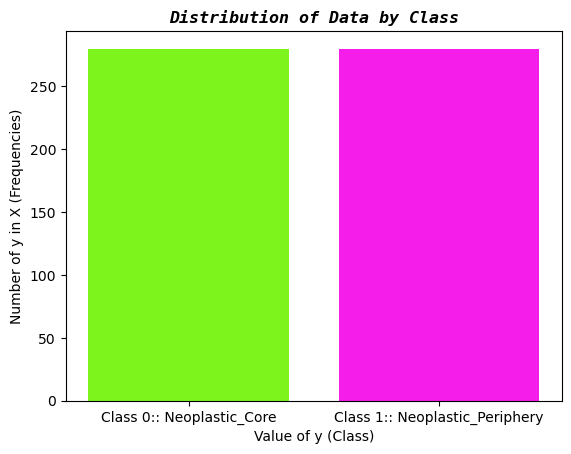


Success! Class counts are now as follows:

Class=0, n=280 (50.000%)
Class=1, n=280 (50.000%)


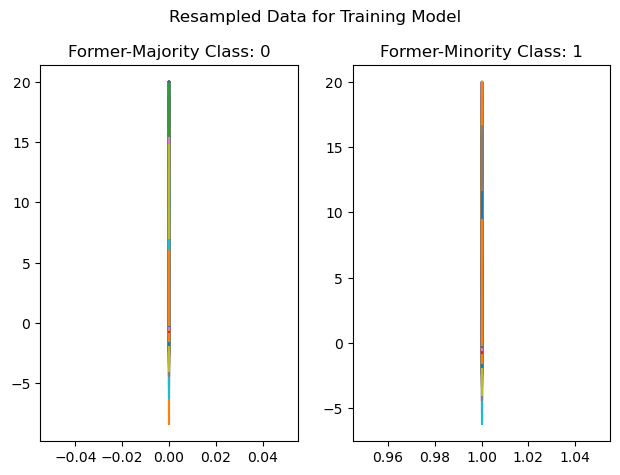

		...The class data has been effectively balanced...



<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>




In [33]:
# Apply class balancing techniques on partitioned variables, where 
# PARAMETERS: X_train_term refers to all variables in the Training Set which are features
#             y_train_term refers to all class labels (target variables) in the Training Set
#             class_equality_term refers to the boolean resulting from function preprocess_data()

def balance_classes(X_train_term, y_train_term, class_equality_term):
    # Check if class distribution presents an imbalance problem & if so, solve it
    if class_equality == False:

        # If class disparity is over 10%, apply balancing techniques
        class_dist = y_train_term.value_counts()
        if (max(class_dist) - min(class_dist)) / sum(class_dist) > .1:

            try:
                # Balance the data
                print('\n<< ---------- ADDRESSING CLASS IMBALANCE PROBLEM ---------- >> \n')
                print(f'\nBecause we observe a 10% or greater disparity between our class distributions,\n' \
                      f'\twe will apply a balancing technique in order to promise a more accurate model fitting.\n')

                # Combine over- and under-sampling as Resampling Method
                resampler = SMOTEENN(sampling_strategy='all',                          # upsample minority class
                                     random_state=42,                                  # set seed of random state generator
                                     smote=SMOTE(sampling_strategy='not majority'),                 # default: SMOTE() oversampling
                                     enn=EditedNearestNeighbours(sampling_strategy='not minority'), # default: ENN() undersampling
                                     n_jobs=1)                                         # default: 1 CPU core used during cross-val loop
                which_sample = str('class') if len(class_dist)==2 else str('classes')
                print(f'\nResampling the data: oversampling minority {which_sample} via SMOTE technique...' \
                      f'\n\t\t     downsampling majority {which_sample} via ENN technique...\n')                

                # Resample training data using SMOTE & ENN techniques
                X_rsampled, y_rsampled = resampler.fit_resample(X_train_term, y_train_term)
                print(f'Resampled Data shape: %s ' % Counter(y_rsampled),'\n')

                # Plot the new distribution
                colors = ['#7df51d','#f51de9']
                labels = [x for x in y_rsampled.value_counts().index]
                plt.bar(labels, y_rsampled.value_counts(), color=colors)
                plt.title('Distribution of Data by Class',
                    fontsize='large',
                    fontweight='bold',
                    style='italic',
                    family='monospace')
                plt.xticks(labels, ['Class 0:: Neoplastic_Core','Class 1:: Neoplastic_Periphery'])
                plt.xlabel('Value of y (Class)')
                plt.ylabel('Number of y in X (Frequencies)')
                plt.show()

                # Summarize the new distribution
                print(f'\nSuccess! Class counts are now as follows:\n')
                counter = Counter(y_rsampled)
                for k, v in counter.items():
                    per = v / len(y_rsampled) * 100
                    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

                # Display resampled distribution of numerical values per class
                if which_sample == 'class':
                    classA, classB = 0, 1
                else:
                    classA, classB = '0', '1'
                fig, ax = plt.subplots(1,2)
                ax[0].set_title(f'Former-Majority Class: {classA}')
                ax[0].plot(y_rsampled[y_rsampled==classA], X_rsampled[y_rsampled==classA].values)
                ax[1].set_title(f'Former-Minority Class: {classB}')
                ax[1].plot(y_rsampled[y_rsampled==classB], X_rsampled[y_rsampled==classB].values)
                fig.suptitle('Resampled Data for Training Model')
                fig.tight_layout()
                plt.show()
                print('\t\t...The class data has been effectively balanced...\n')
                print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
                
                return X_rsampled, y_rsampled

            except:
                print('\n<< ---------- ERROR: There was a problem during balancing ---------- >> \n')
        else:
            print('\n\n\t<<<---------- NO CLASS IMBALANCE PROBLEM FOUND! ---------->>>\n\n')
            print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
    else:
        print('\n\n\t<<<---------- CLASS IMBALANCE IS LESS THAN 10% ---------->>>\n\n')
        print('\n\n<<<---------------------- TRAINING MODEL IS READY FOR FITTING ---------------------->>>\n\n')
        
                
# Run function on training data to solve any class imbalance problem   
X_train, y_train = balance_classes(X_train, y_train, class_equality)

In [34]:
X_train_copy, X_test_copy, y_train_copy, y_test_copy = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [35]:
X_train, X_test, y_train, y_test = X_train_copy.copy(), X_test_copy.copy(), y_train_copy.copy(), y_test_copy.copy()

***
# *** Machine Learning ***
With our training data successfully balanced, cleansed of noise and irrelevant variables, we are ready to train our model for optimum efficiency.
##### * Running the Model * 
We will be using `MLPClassifier`, a Neural Network classification algorithm which predicts output based on a system of inputs. The algorithm receives a series of inputs via an activation function and calculates the weights of the inputs as scalars in a series of nonlinear regression formulas. The MLP then delivers the output as input to the next set of formulas, sifting the data through layers of output/input computations by taking the dot product each time with the corresponding scalars (weights) in the layer, and redefining its internal equations automatically via a backpropagation algorithm in order to minimize any marginal error found during computation of established formulas and new weights introduced via the input. Accordingly, we can more correctly assign labels of the target variable to new, incoming inputs as the model obtains and computes more data (i.e. 'learns'). 
<br><br>
The output as well as the multiple levels of hidden layers (thus the name `MultiLayer Perceptron`) are based on probabilistic modeling between **two distinct class variables** in order to deliver discrete binary results, meaning that the principle effort the algorithm makes is to eliminate errors of judgment between a single value (true positive) and those which do not represent the value (true negative). To evaluate this measure, our primary interest in reading our results obtained will be in attaining as high a sensitivity (true positive) as possible, given that true positives are paramount in order to detect the correct location of the origination of a Glioblastoma patient's cancer cells in order to improve accuracy for therapeutic treatment. Our secondary interest, which is perhaps less costly but of utmost importance nonetheless, is to attain as high a specificity (true negative) as possible, given that true negatives amount to eliminating false origination determinations and needless expenditures. Of course overall, we wish to obtain as few errors (false positives and false negatives) as possible.

In [36]:
# Define Classification Model
model = MLPClassifier(hidden_layer_sizes=(150,100,50),
                      max_iter=100,
                      activation='relu',
                      solver='sgd',
                      alpha=0.0001,
                      random_state=174,
                      early_stopping=False)

# Feed training data to Classifier Model
model.fit(X_train, y_train)

# Output prediction data using X data passed through model
y_pred = model.predict(X_test)
basic_accuracy = accuracy_score(y_test, y_pred)

# Display the results of our testing model
print ('Accuracy:', accuracy_score(y_test, y_pred))
print ('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print ('Recall:', recall_score(y_test, y_pred, average='weighted'))
print ('Precision:', precision_score(y_test, y_pred, average='weighted'))
print ('\nClassification Report:\n', classification_report(y_test, y_pred))
print ('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.9375
F1 score: 0.9326408885232416
Recall: 0.9375
Precision: 0.934197651663405

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97        70
           1       0.86      0.60      0.71        10

    accuracy                           0.94        80
   macro avg       0.90      0.79      0.84        80
weighted avg       0.93      0.94      0.93        80

Confusion Matrix:
 [[69  1]
 [ 4  6]]


Our results appear encouraging with a $93.75\%$ accuracy score, but we may still have some room for improvement. Here we see that our trained model correctly guessed 75 of our 80 actual values, meaning our model correctly classified 69/70 `Neoplastic_Core` and 6/10 `Neoplastic_Periphery` as they were actually labeled, and misclassified 1/70 `Neoplastic_Core` and 4/10 `Neoplastic_Periphery` as they were actually labeled. In our confusion matrix, the upper-left value 69 represents the values which were both predicted as `0` and *actually* `0`, thus giving us the term *true positive*. Conversely, the lower-right value 6 represents the values which were both predicted as `1` and *actually* `1`, giving us the term *true negative*. Just as a reminder, 'positive' and 'negative' are not value quantifiers (i.e. they don't mean a person has cancer or not), but rather class qualifiers- so 'positive' means 'Class 0' and 'negative' means 'Class 1' for our interpretations. 'Class 1', or 'negative', indicates the smaller class. The low score on our underrepresented class is both disconcerting but not unexpected, given our low quantity of samples (remember we started with 58). Our attempt at balancing our classes may not have been sufficient to improve our baseline model's predictive power. Therefore, we will attempt two techniques of hyperparameter tuning in an attempt to improve accuracy of our MLP Classifier model before deploying our final model accuracy determination of testing our unseen data reserve.
<br><br>
We will attempt the implementation of Principal Component Analysis (PCA) in order to remove statistical outliers: data outside 95%, or beyond 3 standard deviations, of normal data.

In [37]:
# Create a PCA-sifted training set for hyperparameter comparison
X_train_PCA, X_test_PCA, y_train_PCA = X_train.copy(), X_test.copy(), y_train.copy()

# Eliminate 5% of statistical outlier data (retain 95% variance in data)
pca = PCA(.95)
pca.fit(X_train_PCA)

# Transform features in X-data sets
X_train_PCA = pca.transform(X_train_PCA)
X_test_PCA = pca.transform(X_test_PCA)

# Store for later comparison
X_train_PCA_copy, X_test_PCA_copy = X_train_PCA.copy(), X_test_PCA.copy()

Now that we've reiterated our processes using our new PCA-styled data through model training, we will implement GridSearchCV cross-fold stratification technique to reiterate random resampling of the data.

In [38]:
print('\n<<<---------------------- BEGIN HYPERPARAMETER TUNING ---------------------->>>\n')
# Create new model using default parameters and only specify iteration count
mlp = MLPClassifier()

# Define a hyperparameter space to search for best combination of parameter options
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'max_iter': [100, 500],
    'learning_rate': ['constant','adaptive']}


<<<---------------------- BEGIN HYPERPARAMETER TUNING ---------------------->>>



In [39]:
# Trying more values (beware of computational time!)
# Define a hyperparameter space to search for best combination of parameter options
extended_parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (150,100,50), (100,)],
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['lbfgs','sgd','adam'],
    'alpha': [0.0001, 0.001, 0.05, 0.1],
    'max_iter': [100, 500, 1000],
    'learning_rate': ['constant','invscaling','adaptive']}

**NOTE!** We initially ran the above `parameter_space` to include several variables in order to find our best estimators (see `extended_parameter_space`), but our algorithm took the better part of a full day to finish processing. Therefore, for the sake of getting this homework assignment submitted in a timely manner as well as to keep our professor from stressing out his resources as we had ours, we will minimize our formula to just a few parameter choices.

In [40]:
print('\n<< ---------- GRIDSEARCHCV PARAMETER TUNING ---------- >> \n')
# Search hyperparameters to find best parameters given our data
print('Searching for optimal parameters..........')
print('....this usually takes quite some time....\n')

# Fit the training data to the model
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

# Determine optimal parameter values
print('\nBest parameters found using GridSearchCV:\n', clf.best_params_,'\n\n')

# Express any meaningful results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
print(f'The following parameters meet or exceed our previous accuracy of {basic_accuracy}:\n')
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    if mean >= basic_accuracy:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Present classification report & confusion matrix
print('\nResults on test set using GridSearchCV hyperparameter tuning:')
print(classification_report(y_test, clf.predict(X_test)))
print ('Confusion Matrix:\n',confusion_matrix(y_test, clf.predict(X_test)))


<< ---------- GRIDSEARCHCV PARAMETER TUNING ---------- >> 

Searching for optimal parameters..........
....this usually takes quite some time....


Best parameters found using GridSearchCV:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'sgd'} 


The following parameters meet or exceed our previous accuracy of 0.9375:

0.977 (+/-0.024) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'sgd'}
0.963 (+/-0.029) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
0.968 (+/-0.042) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'sgd'}
0.964 (+/-0.037) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate'

In [41]:
print('\n\n<< ---------- PCA with GRIDSEARCHCV PARAMETER TUNING ---------- >> \n')
# Search hyperparameters to find best parameters given our data
print('Searching for optimal parameters..........')
print('....this usually takes quite some time....\n')

# Fit the training data to the model; we'll need to create another class instance of GSCV
clf_PCA = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf_PCA.fit(X_train_PCA, y_train_PCA)

# Determine optimal parameter values
print('\nBest parameters found using PCA and GridSearchCV:\n', clf_PCA.best_params_,'\n\n')

# Express any meaningful results
means = clf_PCA.cv_results_['mean_test_score']
stds = clf_PCA.cv_results_['std_test_score']
print(f'The following parameters meet or exceed our previous accuracy of {basic_accuracy}:\n')
for mean, std, params in zip(means, stds, clf_PCA.cv_results_['params']):
    if mean >= basic_accuracy:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Present classification report & confusion matrix
print('\nResults on test set using PCA on training set & GridSearchCV hyperparameter tuning:')
print(classification_report(y_test, clf_PCA.predict(X_test_PCA)))
print ('Confusion Matrix:\n',confusion_matrix(y_test, clf_PCA.predict(X_test_PCA)))

print('\n<<<---------------------- HYPERPARAMETER TUNING COMPLETE ---------------------->>>\n')



<< ---------- PCA with GRIDSEARCHCV PARAMETER TUNING ---------- >> 

Searching for optimal parameters..........
....this usually takes quite some time....


Best parameters found using PCA and GridSearchCV:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'sgd'} 


The following parameters meet or exceed our previous accuracy of 0.9375:

0.948 (+/-0.026) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'sgd'}
0.961 (+/-0.033) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'sgd'}
0.954 (+/-0.046) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'sgd'}
0.945 (+/-0.044) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50

In [ ]:
print('\n\n<< ---------- PCA with GRIDSEARCHCV PARAMETER TUNING ---------- >> \n')
# Search hyperparameters to find best parameters given our data
print('Searching for optimal parameters..........')
print('....this usually takes quite some time....\n')

# Fit the training data to the model; we'll need to create another class instance of GSCV
clf_PCA = GridSearchCV(mlp, extended_parameter_space, n_jobs=-1, cv=5)
clf_PCA.fit(X_train_PCA, y_train_PCA)

# Determine optimal parameter values
print('\nBest parameters found using PCA and GridSearchCV:\n', clf_PCA.best_params_,'\n\n')

# Express any meaningful results
means = clf_PCA.cv_results_['mean_test_score']
stds = clf_PCA.cv_results_['std_test_score']
print(f'The following parameters meet or exceed our previous accuracy of {basic_accuracy}:\n')
for mean, std, params in zip(means, stds, clf_PCA.cv_results_['params']):
    if mean >= basic_accuracy:
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Present classification report & confusion matrix
print('\nResults on test set using PCA on training set & GridSearchCV hyperparameter tuning:')
print(classification_report(y_test, clf_PCA.predict(X_test_PCA)))
print ('Confusion Matrix:\n',confusion_matrix(y_test, clf_PCA.predict(X_test_PCA)))

print('\n<<<---------------------- HYPERPARAMETER TUNING COMPLETE ---------------------->>>\n')

Our hyperparameter tuning returned the following best estimators (very little difference!):

Best parameters found using GridSearchCV:<br>
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'sgd'}
 <br><br>
 Best parameters found using PCA and GridSearchCV:<br>
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'sgd'} 

In [ ]:
# Reimport pre-fitted training sets
X_train_final, y_train_final, y_train_final_PCA = X_train_copy.copy(), y_train_copy.copy(), y_train_copy.copy()
X_train_final_PCA, X_test_final_PCA = X_train_PCA_copy.copy(), X_test_PCA_copy.copy()

# Define Classification Model using Best Estimator7
hyp_A = MLPClassifier(hidden_layer_sizes=(50,50,50),
                      learning_rate='constant',
                      max_iter=500,
                      activation='relu',
                      solver='sgd',
                      alpha=0.0001,
                      random_state=174,
                      early_stopping=False)
hyp_B = MLPClassifier(hidden_layer_sizes=(50,100,50),
                      learning_rate='constant',
                      max_iter=500,
                      activation='relu',
                      solver='sgd',
                      alpha=0.0001,
                      random_state=174,
                      early_stopping=False)

# Feed training data to Classifier Model
hyp_A.fit(X_train_final, y_train_final)
hyp_B.fit(X_train_final_PCA, y_train_final_PCA)

# Output prediction data using X data passed through model
y_pred_A, y_pred_B = hyp_A.predict(X_test), hyp_B.fit(X_test_final_PCA)

# Display the results of our testing model using baseline tuned with GridSearchCV
print ('Accuracy:', accuracy_score(y_test, y_pred_A))
print ('F1 score:', f1_score(y_test, y_pred_A, average='weighted'))
print ('Recall:', recall_score(y_test, y_pred_A, average='weighted'))
print ('Precision:', precision_score(y_test, y_pred_A, average='weighted'))
print ('\nClassification Report:\n', classification_report(y_test, y_pred_A))
print ('Confusion Matrix:\n',confusion_matrix(y_test, y_pred_A))

# Display the results of our testing model using PCA tuned with GridSearchCV
print ('Accuracy:', accuracy_score(y_test, y_pred_B))
print ('F1 score:', f1_score(y_test, y_pred_B, average='weighted'))
print ('Recall:', recall_score(y_test, y_pred_B, average='weighted'))
print ('Precision:', precision_score(y_test, y_pred_B, average='weighted'))
print ('\nClassification Report:\n', classification_report(y_test, y_pred_B))
print ('Confusion Matrix:\n',confusion_matrix(y_test, y_pred_B))

# Display the best!
print('\n<<<---------------------- BEST ESTIMATOR RESULTS ---------------------->>>\n')
best_model = 'baseline' if accuracy_score(y_test, y_pred_A) > accuracy_score(y_test, y_pred_B) else 'PCA'
print(f'\t...Our best hyperparameter tuner is the {best_model} using GridSearchCV!...\n')

Reviewing these results, we can't help but point out the incredible computational time savings the PCA method allowed us. However, we achieved better overall performance in terms of accuracy, F1 score, and specificity with our baseline model using only GridSearchCV hyperparameter tuning. More notably, the optimal parameters returned by both our baseline and PCA-optimized models were identical, however there were a larger quantity of high-performing mean values returned by the baseline model than the PCA model.
<br><br>
We can deduce from these readings that the additional component reductionality we performed on our training model may have contributed to poor specificity while increasing sensitivity.
<br><br>
Using these results, we will finalize our model with our best parameters:<br>
{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'sgd'}

In [43]:
# Make predictions on testing data using best parameters found
best_clf = MLPClassifier(activation='relu',
                        alpha=0.05,
                        hidden_layer_sizes=(50,100,50),
                        learning_rate='adaptive',
                        max_iter=100,
                        solver='sgd')
best_clf.fit(X_train, y_train)
y_pred = best_clf.predict(X_test)

# Display the results of our new testing model
print ('Accuracy:', accuracy_score(y_test, y_pred))
print ('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print ('Recall:', recall_score(y_test, y_pred, average='weighted'))
print ('Precision:', precision_score(y_test, y_pred, average='weighted'))
print ('\nClassification Report:\n', classification_report(y_test, y_pred))
print ('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

Accuracy: 0.95
F1 score: 0.9534313725490196
Recall: 0.95
Precision: 0.9642857142857142

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        70
           1       0.71      1.00      0.83        10

    accuracy                           0.95        80
   macro avg       0.86      0.97      0.90        80
weighted avg       0.96      0.95      0.95        80

Confusion Matrix:
 [[66  4]
 [ 0 10]]


In [44]:
# Store finalized model data
X_train_final, X_test_final = X_train.copy(), X_test.copy()
y_test_final, y_train_final = y_test.copy(), y_train.copy()
X_train_final_PCA, X_test_final_PCA = X_train_PCA.copy(), X_test_PCA.copy()
y_train_final_PCA = y_train_PCA.copy()

***
### Final Testing :: Cross-Validation
Now we're ready to apply our model to our untouched data which we set aside at the beginning of our project. This will be the true test of our model's capacity to handle new data in the future.

In [ ]:
# Run function on dataframe and boolean variable to prepare data to fit model
X, y = preprocess_data(data_unseen, class_equality)

# Run function on X & y variables to split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y)

# Run function on training data to solve any class imbalance problem  
X_train, y_train = balance_classes(X_train, y_train, class_equality)

# Define Classification Model
best_model = MLPClassifier(hidden_layer_sizes=(50,100,50),
                      max_iter=100,
                      activation='relu',
                      solver='sgd',
                      alpha=0.05,
                      learning_rate='adaptive')

# Feed training data to Classifier Model
best_model.fit(X_train, y_train)

In [73]:
# Bring back the reserved data, drop the column labels and run the model on the data
colnames = [x for x in data_unseen.columns]
y_raw = data_unseen[colnames[0]]
X_raw = data_unseen.drop(colnames[0], axis=1)

# ValueError: X has 16383 features, but MLPClassifier is expecting 11572 features as input.
# ---> We have to randomly ditch the difference in features <---
cols_to_drop = X_raw.shape[1] - X_train.shape[1]
cols_to_keep = 1-cols_to_drop/X_raw.shape[1]
X_raw = X_raw.columns.drop(colnames.sample(frac=cols_to_keep))

X_raw.shape

AttributeError: 'list' object has no attribute 'sample'

In [66]:
# Bring back the reserved data, drop the column labels and run the model on the data
colnames = [x for x in data_unseen.columns]
y_raw = data_unseen[colnames[0]]
X_raw = data_unseen.drop(colnames[0], axis=1)

# ValueError: X has 16383 features, but MLPClassifier is expecting 11572 features as input.
# ---> We have to randomly ditch the difference in features <---
cols_to_drop = X_raw.shape[1] - X_train.shape[1]
cols_to_keep = 1-cols_to_drop/X_raw.shape[1]
X_raw = X_raw.sample(frac=(cols_to_keep), 
                     random_state=312).reset_index(drop=True)

# Output prediction data using X data passed through model
y_pred = best_clf.predict(X_raw)
best_accuracy = accuracy_score(y_test, y_pred)

# Display the results of our testing model
print ('Accuracy:', accuracy_score(y_test, y_pred))
print ('F1 score:', f1_score(y_test, y_pred, average='weighted'))
print ('Recall:', recall_score(y_test, y_pred, average='weighted'))
print ('Precision:', precision_score(y_test, y_pred, average='weighted'))
print ('\nClassification Report:\n', classification_report(y_test, y_pred))
print ('Confusion Matrix:\n',confusion_matrix(y_test, y_pred))

ValueError: X has 16383 features, but MLPClassifier is expecting 11572 features as input.

***
# Conclusion
We find that our best results are using the baseline parameters with GridSearchCV hyperparameter tuning, giving us an optimal accuracy score of $95\%$ for our model testing data, and $?\%$ for our untouched reserve data. We believe this is likely due to the classifier's backpropagating iterative process native to its design. Since the algorithm is built to learn the best weighting methods to balance its own system of equations, it's reasonable to deduce that the algorithm optimizes itself best by its own automatic features, and our best approach to using this powerful algorithm is to carefully prepare the data first *before* presenting it to the model for training. Applying PCA linear reduction after we had already removed collinear variables and scaled the data caused a decrease in overall performance by increasing sensitivity but decreasing specificity (allowing too many negatives). Order proved imperative to our process, and working with this powerful algorithm gives us both great opportunity but great responsibility in properly handling our data.
<br><br>
Using this care in approaching our model, we were able to obtain a model optimized to handle unseen data and future prediction tasks.